![logo](../../LogoLine_horizon_C3S.png)

<div class="alert alert-block alert-warning">
Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch
</div>

# Assessing the impact of scale and temporal trends for seasonal forecast quality

Production date: 30.04.2025

Produced by: Johannes Langvatn (METNorway), Johanna Tjernström (METNorway)

## 🌍 Use case: How effectively can seasonal forecasts predict the development of key global climate variables across varying spatial scales?

## ❓ Quality assessment question
* How does the quality of seasonal forecasts change when looking at different sized areas? What are the associated limitations?
* How do long term temporal trends impact the quality of seasonal forecasts?

The effectiveness of seasonal forecasts in predicting the development of key climate variables—such as temperature, precipitation and sea surface temperatures (SSTs)—varies considerably by variable, region, season, lead time and the state of large-scale climate drivers like ENSO (El Niño–Southern Oscillation). This notebook investigates how a potential trend in the data (e.g. as discussed in [Greuell et al. (2019) \[1\]](https://doi.org/10.5194/hess-23-371-2019)) along with selection of regions at various spatial scales (e.g. as discussed in [Prodhomme et al. (2021) \[2\]](https://doi.org/10.1007/s00382-021-05828-3), [Gubler et al. (2020) \[3\]](https://doi.org/10.1175/WAF-D-19-0106.1) [Quaglia et al. (2021) \[4\]](https://doi.org/10.1007/s00382-021-05895-6)) affect forecasting quality

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* The forecast quality (ensemble mean correlation) of t2m varies depending on the selected spatial scale and the choice of the regions or locations.
  * There is a clear drop in forecast quality when moving from the global scale to continental scale (Europe), to a national scale (Germany), and finally to a city scale (Bonn).
  * This is not the case when comparing the global scale, to the Pacific and NINO region, where the forecast quality remains largely constant, or even better, the smaller the selected region.
  * The regional mean for NINO3.4 is better correlated to the reanalysis than the global regional mean
  * The nearest grid cell to Bonn (an example city in Germany) has low correlation and most of the quality can be attributed to the underlying trend in the dataset
  * In contrast, the nearest grid cell to Addis Ababa (an example city in Eastern Africa) has some correlation which is retained even after detrending
* For regions and locations which have a visible trend in t2m, the trend inflates the correlation of t2m compared to reanalysis.
  * For Europe, most of the visible correlation can be attributed to the underlying trend
  * This contrasts with the region of greater horn of Africa, where less of the visible correlation can be attributed to the underlying trend
* Users are generally advised to avoid selecting small regions or single grid cells when using seasonal forecasts as they are only expected to be skillful in predicting large scale variations in monthly or seasonal deviations. Selecting larger regions based on a common climatology generally results in increased robustness and signal to noise
```

## 📋 Methodology

This notebook provides an assessment of the quality of seasonal monthly forecast temperature anomalies derived from the monthly means (https://cds.climate.copernicus.eu/datasets/seasonal-monthly-single-levels) through comparison with the ERA5 reanalysis (https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means). The hindcast anomalies are calculated from the monthly means as the anomalies catalogue entry only provides the real time forecasts. Data were accessed from the CDS.

Using this data the anomaly was calculated for the two meter temperature (t2m), against the period 1993-2024, and was detrended assuming a linear trend. A dataset was then generated containing both the original anomaly and the detrended. The analysis was then carried out globally and for three regions chosen based on effects of trend on the correlation. 

First, the global case was considered both including and excluding trend, plotting anomaly for the ensemble members, ensemble mean, and ERA5. The correlation was also calculated.

To further consider the correlation, maps were generated to more clearly view the spatial variations of correlation in anomaly (as can seen on the [C3S verification page](https://confluence.ecmwf.int/display/CKB/C3S+seasonal+forecasts+verification+plots)) between the seasonal forecast and ERA5. Based on these maps, a set of regions were selected for further study, based on the magnitude of the correlation.
Plots were then generated for nested domains. Three spatial scales were considered, a larger, continental scale, a smaller country scale and a much smaller city scale. Data were selected for each domain based on a lat/lon box.


The resulting plots, displaying the ensemble members, ensemble mean, and ERA5, aim to visualise the variation in quality based on the selected regions of interest. This was also done for the detrended anomaly, and correlation was also calculated for each of the domains. 


**[](seasonal_seasonal-monthly-single-levels_resolution_q06:section-1)**
 * Choose a selection of forecast systems and model versions, hindcast period (normally 1993-2016 to align with the C3S common hindcast period), forecast and leadtime months
 * Compute the anomaly of the forecast and reanalysis data
 * The data is detrended assuming a linear trend in the data from start year to end year
 * Both the original and detrended data is saved for the following analysis

**[](seasonal_seasonal-monthly-single-levels_resolution_q06:section-2)**
 * Compute the ensemble mean of the forecasted anomaly
 * Plot the correlation of forecast and reanalysis data, before and after performing the detrending
 
**[](seasonal_seasonal-monthly-single-levels_resolution_q06:section-3)**
 * Correlation is plotted for each grid point on a map
 * Based on this, regions are selected to investigate further; Addis Ababa, Bonn, NINO3.4.

**[](seasonal_seasonal-monthly-single-levels_resolution_q06:section-4)**
 * Plots are generated for the regions chosen in the previous section   

## 📈 Analysis and results

(seasonal_seasonal-monthly-single-levels_resolution_q06:section-1)=
### 1. Choose data to use and setup code

This section contains the setup and data processing needed for performing the analysis

Import external code libraries needed

In [1]:
# collapsable code cells - note that the code cell will be collapsed by the addition of a 'hide-input' tag when the Jupyter Book page is built
import os
import numpy as np
import xarray as xr
import matplotlib as mpl
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from c3s_eqc_automatic_quality_control import diagnostics, download, utils
from sklearn.linear_model import LinearRegression

Define functions to be used throughout the notebook

In [2]:
def compute_anomaly(obj):
    climatology = obj.mean({"realization"} & set(obj.dims))
    climatology = diagnostics.time_weighted_mean(climatology, weights=False)
    return obj - climatology

def detrend(obj):
    trend = xr.polyval(obj["time"], obj.polyfit("time", deg=1).polyfit_coefficients)
    return obj - trend

def compute_monthly_anomaly(ds):
    (da,) = ds.data_vars.values()
    with xr.set_options(keep_attrs=True):
        da = da.groupby("time.month").map(compute_anomaly)
        da_detrend = da.groupby("time.month").map(detrend)
    da = xr.concat(
        [da.expand_dims(detrend=[False]), da_detrend.expand_dims(detrend=[True])],
        "detrend",
    )
    da.encoding["chunksizes"] = tuple(
        1 if dim in ("realization", "detrend") else size
        for dim, size in da.sizes.items()
    )
    return da.to_dataset()

def plot_func(dict_with_leadtime_keys, list_of_region_keys, fignums, plot_scale=3, time_range = None):
    if time_range is None:
        time_range = dict_with_leadtime_keys.keys()
    for detrend in [False, True]:
        for leadtime in time_range:
            region_dict = {key : master_dict[leadtime][key] for key in list_of_region_keys}
            
            num_plots = len(list_of_region_keys)
            num_cols = 4#int(np.ceil(num_plots/plot_scale))
            num_rows = num_plots // num_cols 
            if num_plots % num_cols != 0:
                num_rows += 1
            
            fig,axs = plt.subplots(num_rows,num_cols, figsize=(17,4))
            dtrnd = "(Detrended)" if detrend else ""
            fig.suptitle(f"Figure {fignums[0]}: Different regions - t2m "+ dtrnd +f"\n{month_string}")
            fignums.pop(0)
            count_row = 0
            count_col = 0
            for region_name, dictionary in region_dict.items(): 
                data = dictionary["data_sf"]
                lat = dictionary["lat"]
                lon = dictionary["lon"]
                da_reanalysis_mean = dictionary["data_era5"]
                mean_ens = dictionary["mean_ens"]
                if num_cols > 1 and num_rows > 1:
                    ax = axs[count_row,count_col]
                elif num_plots == 1:
                    ax = axs
                else:
                    ax = axs[count_col]
                
                corr = float(xr.corr(mean_ens.sel(detrend=detrend), da_reanalysis_mean.sel(detrend=detrend)))
                data.sel(detrend=detrend).plot.scatter(x="time",hue_style="bo", ax = ax, label ="Realization")
                mean_ens.sel(detrend=detrend).plot.scatter(x="time", color = "r", marker="o", ax = ax, label = "Realization Mean")
                da_reanalysis_mean.sel(detrend=detrend).plot.scatter(x="time", color = "r", marker="x", ax = ax, label = "ERA5")
                ax.set_title(region_name + f" Corr = {corr:.3}")
                with mpl.rc_context({"legend.fontsize": "small", "legend.framealpha" : 0.3}):
                    ax.legend()
                count_col += 1
                if count_col >= num_cols:
                    count_row += 1
                    count_col = 0
            plt.tight_layout()
            plt.show()

def plot_regions(region_dict,regions):
    fig = plt.figure(figsize=(10, 5))
    central = (region_dict[regions[0]]["lon"].start + region_dict[regions[0]]["lon"].stop)/2
    ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=central))
    
    # make the map global rather than have it zoom in to
    # the extents of any plotted data
    ax.set_extent([region_dict[regions[0]]["lon"].start,region_dict[regions[0]]["lon"].stop,
    region_dict[regions[0]]["lat"].start,region_dict[regions[0]]["lat"].stop])
    
    ax.coastlines()
    width = region_dict[regions[1]]["lon"].stop - region_dict[regions[1]]["lon"].start
    height = region_dict[regions[1]]["lat"].stop - region_dict[regions[1]]["lat"].start
    
    ax.add_patch(mpatches.Rectangle(xy=[region_dict[regions[1]]["lon"].start, region_dict[regions[1]]["lat"].start],
                                    width=width, height=height,
                                    facecolor='none', edgecolor='k',lw = 2,
                                    transform=ccrs.PlateCarree()))
    
    ax.plot(region_dict[regions[2]]["lon"].start,region_dict[regions[2]]["lat"].start,marker='o',transform=ccrs.PlateCarree())
    ax.set_title(f"Shows {regions[1]} [box] and {regions[2]} [blue circle] in the {regions[0]} region")
    plt.show()


In [3]:
# Variable
var_api = "2m_temperature"

# Time range
year_start = 1993
year_stop = 2024
collection_id_reanalysis = "reanalysis-era5-single-levels-monthly-means"
collection_id_seasonal = "seasonal-monthly-single-levels"


months = {
    0: "June",
    1: "July",
    2: "August"
}

month_string = "Start month: MAY - Valid month: JUNE"
common_request = {
    "format": "grib",
    "area": [89.5, -179.5, -89.5, 179.5],
    "variable": var_api,
    "grid": "1/1",
    "year": [f"{year}" for year in range(year_start, year_stop + 1)],
}

request_reanalysis = common_request | {
    "product_type": "monthly_averaged_reanalysis",
    "time": "00:00",
    "month": [f"{month:02d}" for month in range(6,9)],
}

request_seasonal = common_request | {
    "product_type": "monthly_mean",
    "system": 51,
    "originating_centre": "ecmwf",
    "month": "5"
}

kwargs = {
    "chunks": {"year": 1},
    "n_jobs": 1,
    "backend_kwargs": {"time_dims": ["valid_time"]},
    "transform_func": compute_monthly_anomaly,
    "transform_chunks": False,
}

# Reanalysis
(da_reanalysis,) = download.download_and_transform(
    collection_id_reanalysis,
    request_reanalysis,
    **kwargs,
).data_vars.values()

# Seasonal forecast
dataarrays = []
for leadtime_month in range(2, 5):
    (da,) = download.download_and_transform(
        collection_id_seasonal,
        request_seasonal | {"leadtime_month": leadtime_month},
        **kwargs,
    ).data_vars.values()
    da["time"] = da.indexes["time"].shift(-1,"MS")
    dataarrays.append(da.expand_dims(leadtime_month=[leadtime_month]))
# Use dataarrays directly... for now
#da_seasonal = xr.concat(dataarrays, "leadtime_month")

(seasonal_seasonal-monthly-single-levels_resolution_q06:section-2)=
### 2. Comparing global correlation

Compute the ensemble mean of the seasonal forecast anomaly data


Plot the original anomaly data for each ensemble member, the ensemble mean, and the reanalysis anomaly.

In [4]:
da_reanalysis_mean = diagnostics.spatial_weighted_mean(da_reanalysis)

# leadtime here maps to index of leadtime_month: 0 is 2, here 0 is forecast for june from may., 2 is forecast for august from may (leadtime_month = 4)
leadtime = 0
data = diagnostics.spatial_weighted_mean(dataarrays[leadtime])
mean_ens = data.mean("realization")

Plot the detrended anomaly data for each ensemble member, the ensemble mean, and the reanalysis anomaly. 

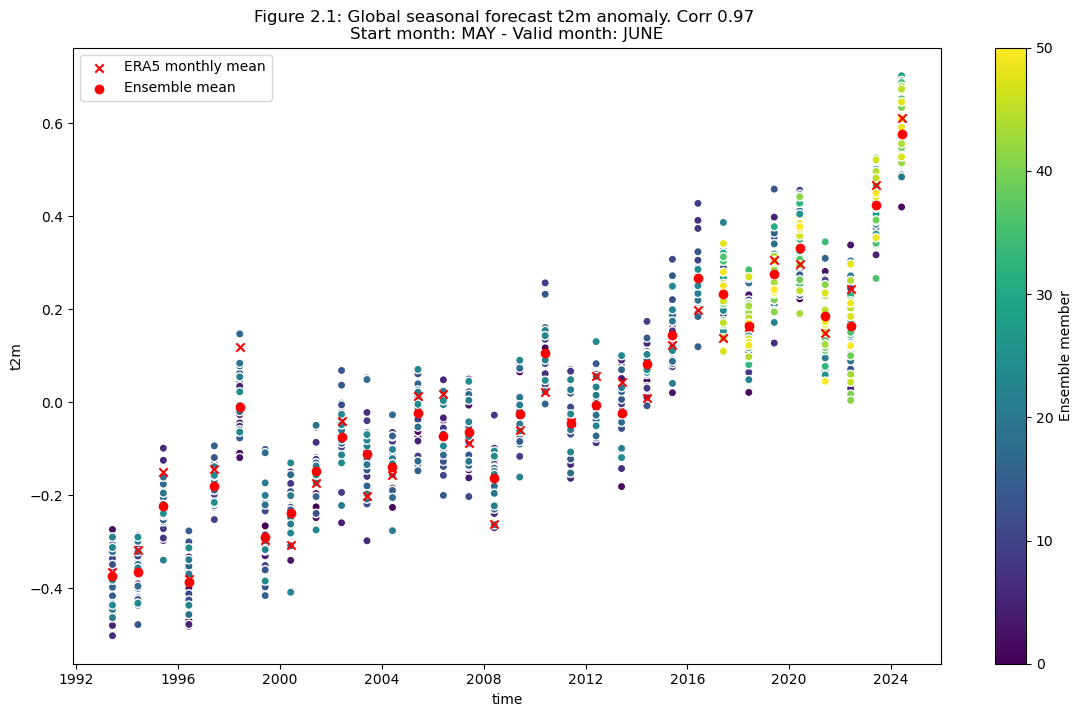

In [5]:
correlation = np.corrcoef(mean_ens.sel(detrend=False).isel(leadtime_month=0).values,da_reanalysis_mean.sel(detrend=False).isel(time=range(0+leadtime,96+leadtime,3)).values)[0,1]
plt.figure(figsize=(14,8))
data.sel(detrend=False).plot.scatter(x="time", hue="realization",cbar_kwargs={"label": "Ensemble member"})
da_reanalysis_mean.sel(detrend=False).isel(time=range(0+leadtime,96+leadtime,3)).plot.scatter(x="time", color = "r", marker="x", label = "ERA5 monthly mean")
mean_ens.sel(detrend=False).plot.scatter(x="time", color = "r", marker="o", label = "Ensemble mean")
fignum="2.1"
plt.title(f"Figure {fignum}: Global seasonal forecast t2m anomaly. Corr {correlation:.2f} \n{month_string}")
plt.legend()
plt.show()

#### Plot after detrending

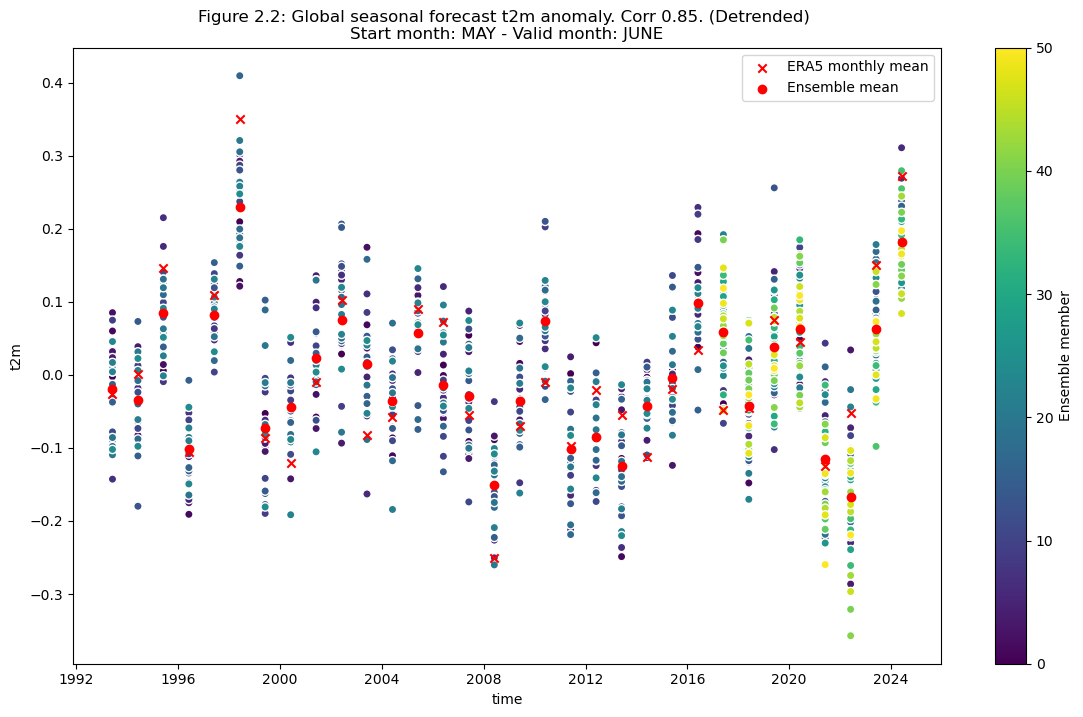

In [6]:
correlation = np.corrcoef(mean_ens.sel(detrend=True).isel(leadtime_month=0).values,da_reanalysis_mean.sel(detrend=True).isel(time=range(0+leadtime,96+leadtime,3)).values)[0,1]
plt.figure(figsize=(14,8))
data.sel(detrend=True).plot.scatter(x="time", hue="realization",cbar_kwargs={"label": "Ensemble member"})
da_reanalysis_mean.sel(detrend=True).isel(time=range(0+leadtime,96+leadtime,3)).plot.scatter(x="time", color = "r", marker="x", label = "ERA5 monthly mean")
mean_ens.sel(detrend=True).plot.scatter(x="time", color = "r", marker="o", label = "Ensemble mean")
fignum="2.2"
plt.title(f"Figure {fignum}: Global seasonal forecast t2m anomaly. Corr {correlation:.2f}. (Detrended) \n{month_string}")
plt.legend()
plt.show()

(seasonal_seasonal-monthly-single-levels_resolution_q06:section-3)=
### 3. Map of correlation for detrended data

The correlation of the detrended data is plotted compared to reanalysis data for each grid cell on a map

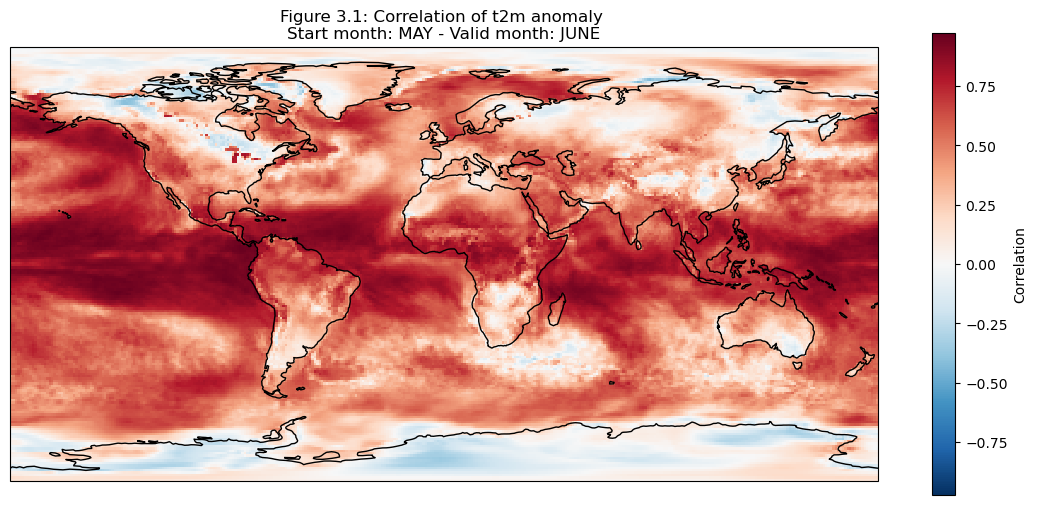

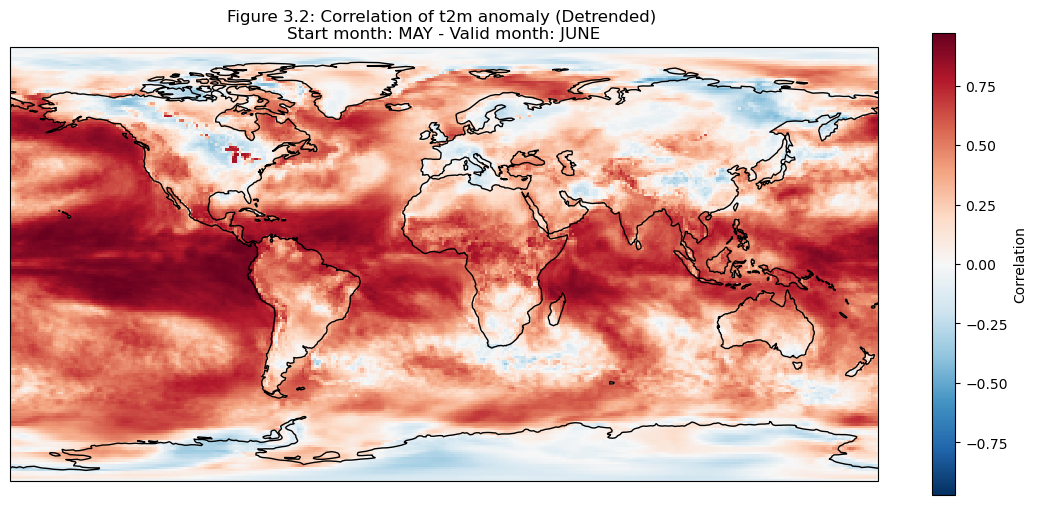

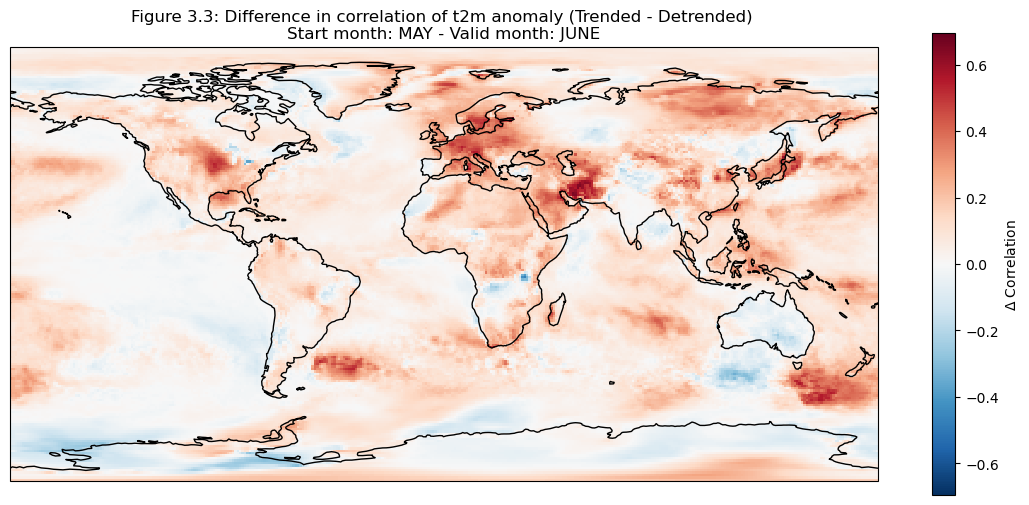

In [7]:
for leadtime in range(1):
    mean_ens = dataarrays[leadtime].mean("realization")
    fig, ax = plt.subplots(figsize=(14,6), subplot_kw=dict(projection=ccrs.PlateCarree()))
    corr = xr.corr(mean_ens.sel(detrend=False).isel(leadtime_month=0),da_reanalysis.sel(detrend=False).isel(time=range(0+leadtime,96+leadtime,3)),dim="time")
    corr.plot(cbar_kwargs={"label": "Correlation"})
    ax.coastlines(resolution="110m")
    fignum="3.1"
    ax.set_title(f"Figure {fignum}: Correlation of t2m anomaly \n{month_string}")
    plt.show()

    fig, ax = plt.subplots(figsize=(14,6), subplot_kw=dict(projection=ccrs.PlateCarree()))
    corr_detrend = xr.corr(mean_ens.sel(detrend=True).isel(leadtime_month=0),da_reanalysis.sel(detrend=True).isel(time=range(0+leadtime,96+leadtime,3)),dim="time")
    corr_detrend.plot(cbar_kwargs={"label": "Correlation"})
    ax.coastlines(resolution="110m")
    fignum="3.2"
    ax.set_title(f"Figure {fignum}: Correlation of t2m anomaly (Detrended) \n{month_string}")
    plt.show()

    fig, ax = plt.subplots(figsize=(14,6), subplot_kw=dict(projection=ccrs.PlateCarree()))
    (corr-corr_detrend).plot(cbar_kwargs={"label": r"$\Delta$ Correlation"})
    ax.coastlines(resolution="110m")
    fignum="3.3"
    ax.set_title(f"Figure {fignum}: Difference in correlation of t2m anomaly (Trended - Detrended) \n{month_string}")
    plt.show()

#### Selecting regions
Based on the correlation maps, regions are selected to investigate further; Addis Ababa, Bonn, NINO3.4.

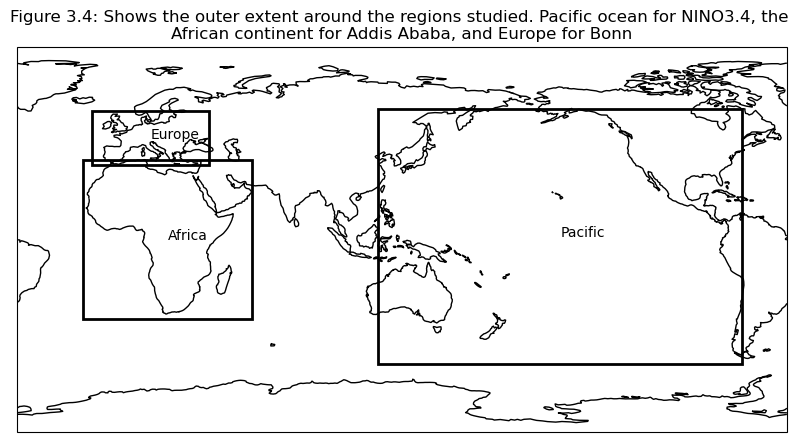

In [8]:
regions = {
    "Global" : {
        "lat":None,
        "lon":None},
    "Europe" : {
        "lat": slice(60, 35),
        "lon": slice(-15, 40)},
    "Germany" : {
        "lat": slice(55, 48),
        "lon": slice(5, 15)},
    "Bonn": {
        "lat": slice(51, 49),
        "lon": slice(6, 8)},
    "Pacific" : {
        "lat": slice(61, -58),
        "lon": slice(-241, -71)},
    "NINO3.4": {
        "lat": slice(5, -5),
        "lon": slice(-170.1, -120.3)},
    "NINO3.4 point": {
        "lat": slice(1, -1),
        "lon": slice(-146, -144)},
    "Africa": {
        "lat": slice(37,-37),
        "lon": slice(-19,60)},
    "Greater Horn of Africa": {
        "lat": slice(19.5, -3.7),
        "lon": slice(23.9, 56.8)},
    "Addis Ababa": {
        "lat": slice(10,8),
        "lon": slice(38,40)},
}

fig = plt.figure(figsize=(10, 5))
central=130
ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=central))
ax.set_global()
ax.coastlines()

for region in ["Europe", "Pacific", "Africa"]:
    region_data =  regions[region]
    width = region_data["lon"].stop - region_data["lon"].start
    height = region_data["lat"].stop - region_data["lat"].start
    mean_lon =  (region_data["lon"].stop + region_data["lon"].start) / 2
    mean_lat =  (region_data["lat"].stop + region_data["lat"].start) / 2
    ax.add_patch(mpatches.Rectangle(xy=[region_data["lon"].start, region_data["lat"].start], width=width, height=height, facecolor='none', edgecolor='k',lw = 2, transform=ccrs.PlateCarree()))
    ax.text(mean_lon, mean_lat, region, transform=ccrs.PlateCarree())
fignum="3.4"
plt.title(f"Figure {fignum}: Shows the outer extent around the regions studied. Pacific ocean for NINO3.4, the \nAfrican continent for Addis Ababa, and Europe for Bonn")
plt.show()

(seasonal_seasonal-monthly-single-levels_resolution_q06:section-4)=
### 4. Plot and describe results
In this section the regional means are computed and plots generated to illustrate scale variations for the selected regions

In [9]:
master_dict = {}
for leadtime in range(3):
    era5_new = da_reanalysis.isel(time=range(0+leadtime,96+leadtime,3))
    sf_ds_new = dataarrays[leadtime]
    out_regions = {}
    for region in regions.keys():
        out_dict={}
        reg_dict = regions[region]
        if reg_dict["lat"] is None and reg_dict["lon"] is None:
            sliced_sf = sf_ds_new
            sliced_era5 = era5_new
        elif reg_dict["lat"] is None and reg_dict["lon"] is not None:
            sliced_sf = sf_ds_new.sel(longitude=reg_dict["lon"])
            sliced_era5 = era5_new.sel(longitude=reg_dict["lon"])
        elif reg_dict["lon"] is None and reg_dict["lat"] is not None:
            sliced_sf = sf_ds_new.sel(latitude=reg_dict["lat"])
            sliced_era5 = era5_new.sel(latitude=reg_dict["lat"])
        else:
            sliced_sf = sf_ds_new.sel(latitude=reg_dict["lat"],longitude=reg_dict["lon"])
            sliced_era5 = era5_new.sel(latitude=reg_dict["lat"],longitude=reg_dict["lon"])
            
        out_dict["lat"] = slice(90, -90) if reg_dict["lat"] is None else reg_dict["lat"]
        out_dict["lon"] = slice(-180, 180) if reg_dict["lon"] is None else reg_dict["lon"]
        out_dict["data_sf"] = diagnostics.spatial_weighted_mean(sliced_sf, weights= True) 
        out_dict["data_era5"] = diagnostics.spatial_weighted_mean(sliced_era5, weights= True)
        out_dict["mean_ens"] = out_dict["data_sf"].mean("realization")
        out_regions[region] = out_dict
    master_dict[leadtime] = out_regions

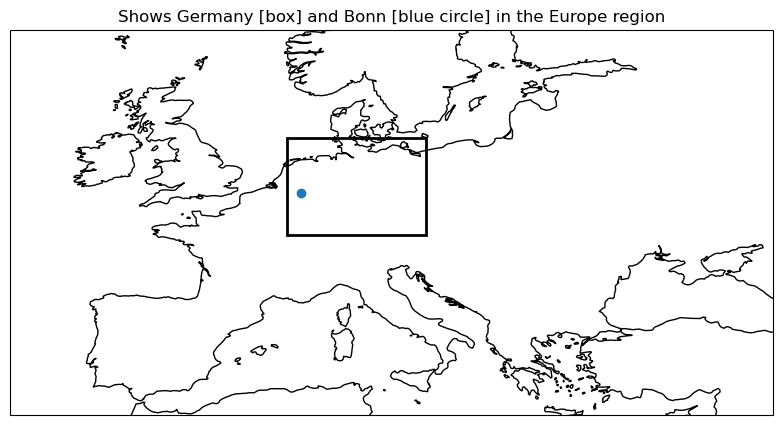

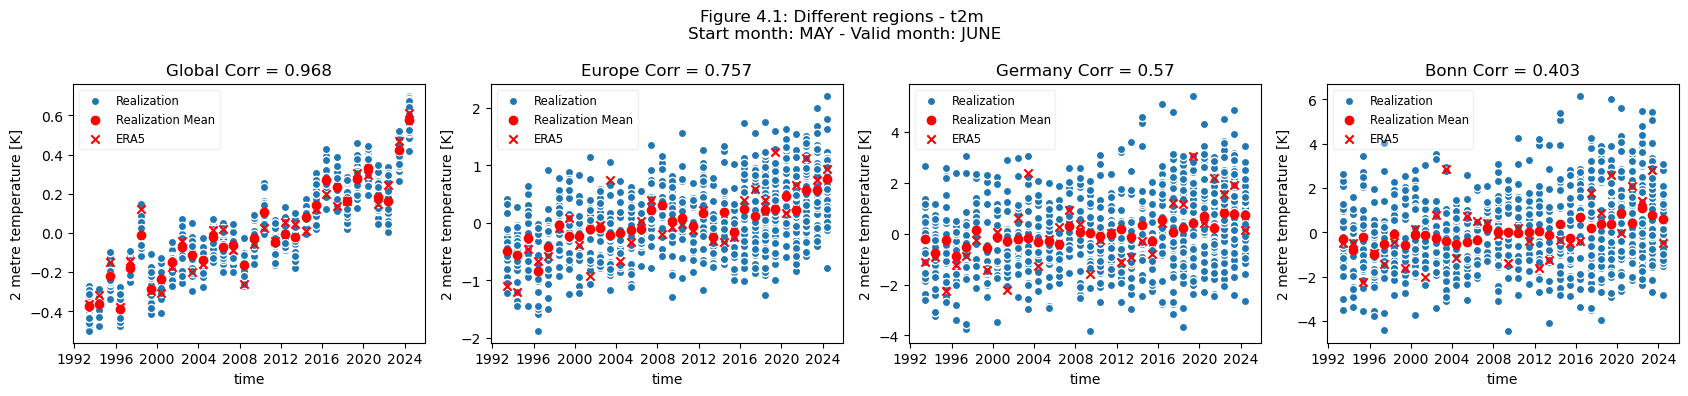

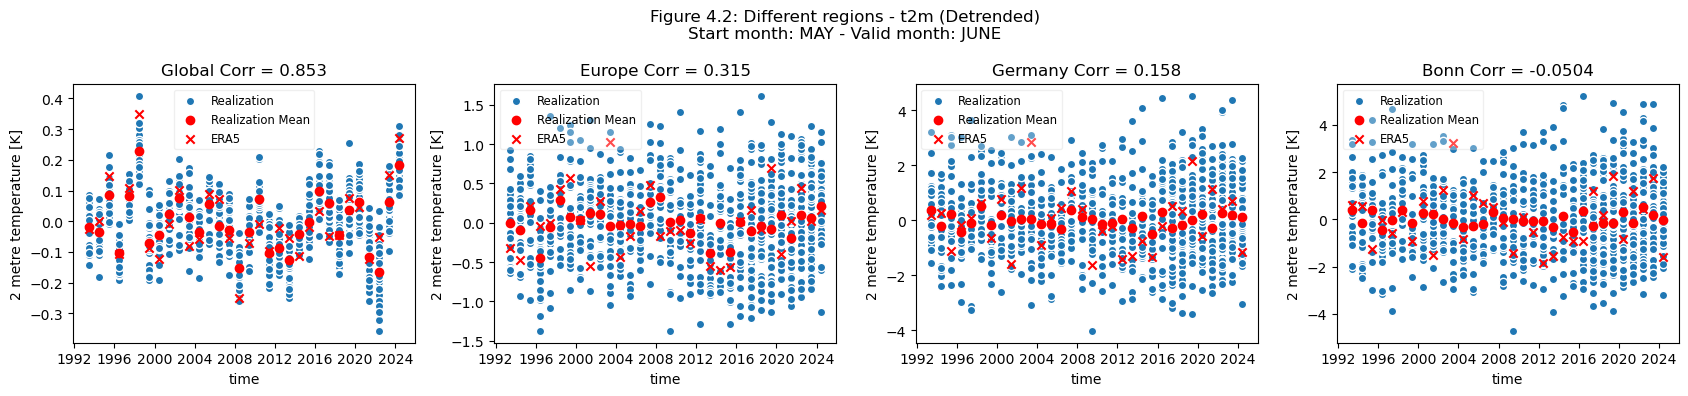

In [10]:
plot_regions(regions,["Europe","Germany","Bonn"])
plot_func(master_dict, ["Global", "Europe", "Germany", "Bonn"], ["4.1","4.2"],time_range=[0])

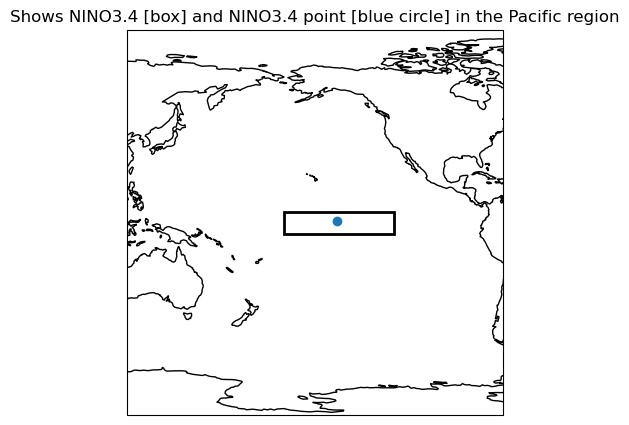

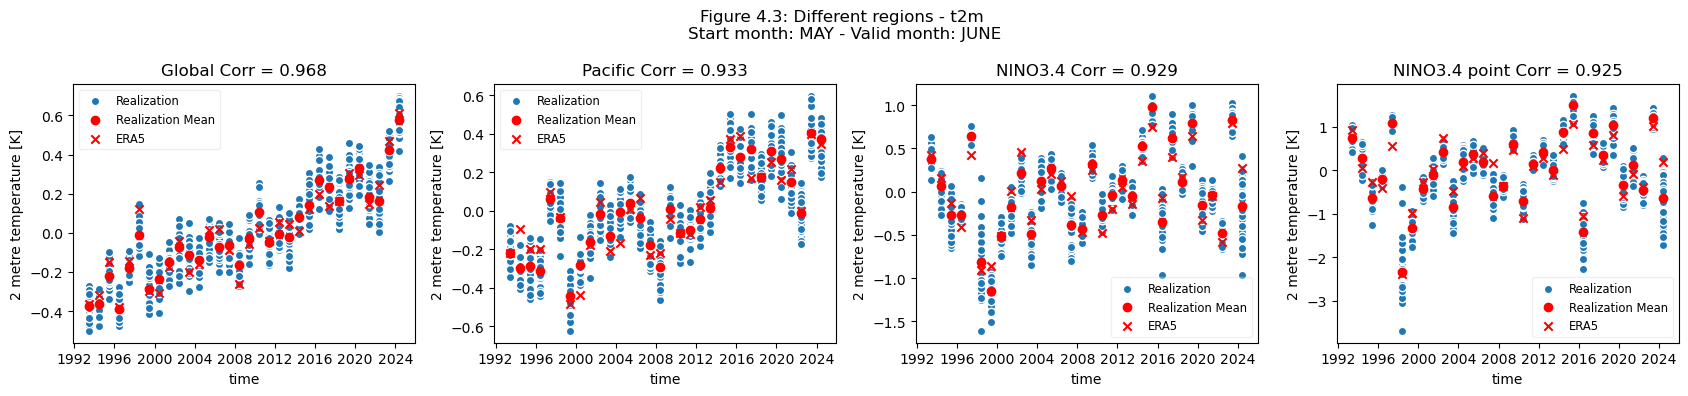

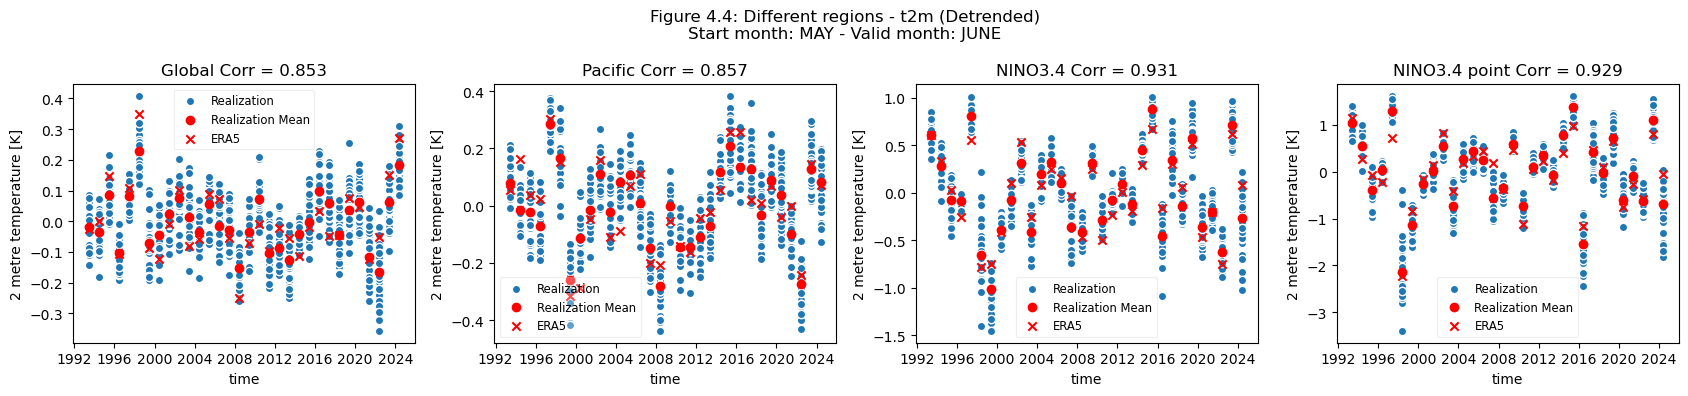

In [11]:
plot_regions(regions, ["Pacific", "NINO3.4", "NINO3.4 point"])
plot_func(master_dict, ["Global", "Pacific", "NINO3.4", "NINO3.4 point"], ["4.3","4.4"], time_range= [0])

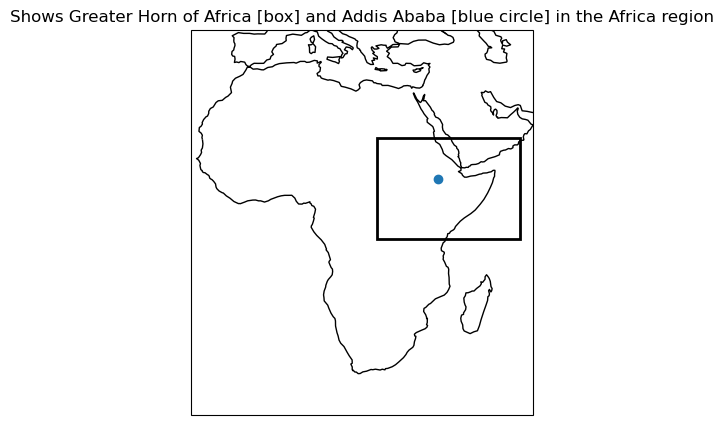

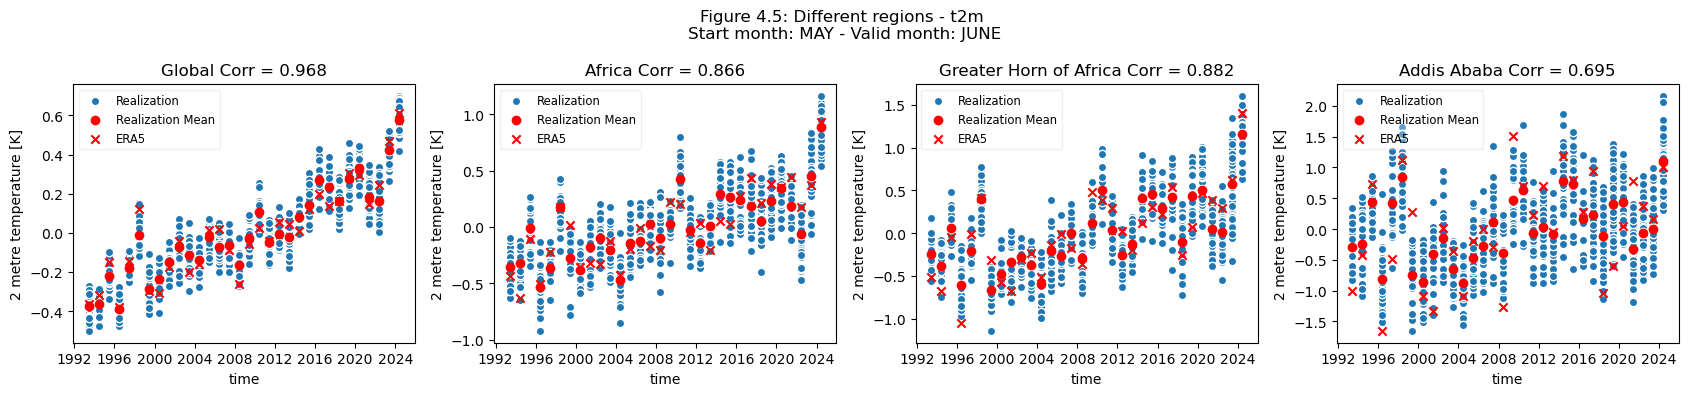

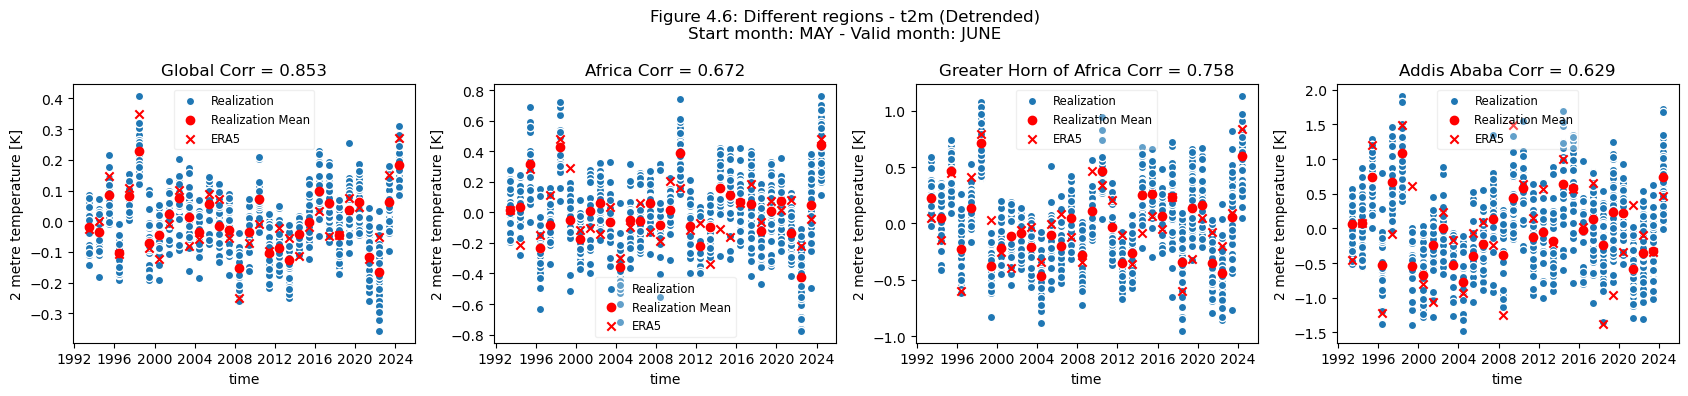

In [12]:
plot_regions(regions, ["Africa", "Greater Horn of Africa", "Addis Ababa"])
plot_func(master_dict, ["Global", "Africa", "Greater Horn of Africa", "Addis Ababa"], ["4.5","4.6"], time_range= [0])

#### Discussion

Looking at the comparison of different regions at different scales a few conclusions can be drawn. Firstly, for regions with a visible trend, that trend inflates the correlation for t2m compared against analysis. This can be seen for Europe, where comparing the detrended and trended plots, the correlation is greater for the data with trend in Europe. Hence, for Europe, most of the visible correlation can be attributed to the underlying trend.


This can be compared with the region of greater horn of Africa. Where comparing the trended and detrended case indicates that less of the visible correlation can be attributed to the underlying trend.


For the selected regions, forecast quality depending on scale varies. Looking at the Europe, Germany, Bonn case, there is a drop in forecast quality as the scale decreases. This cannot be observed in the NINO3.4 where the quality remains more or less constant, despite the decrease in region. The Greater Horn of Africa, where the drop off in quality with scale can be seen somewhat in the case of Addis Ababa, but not on the same scale as can be seen in the Europe case.


Considering this, and the anomalies for the different regions at different scales, it can be seen that the region of NINO3.4 has a better correlation with the reanalysis than the global regional mean, while Bonn has a low correlation where most of the quality can be attributed to the underlying trend. Addis Ababa has some correlation, which is retained even after detrending. However, the high correlations for the NINO3.4 region are partially dependent on the start date and forecast length, which can be seen in the [SST indices plots on the C3S verification page](https://confluence.ecmwf.int/display/CKB/C3S+seasonal+forecasts+verification+plots)), though it should be noted that these plots use sea surface temperature and not t2m.


## ℹ️ If you want to know more

### Key resources

 * Seasonal forecast monthly statistics on single levels: [10.24381/cds.68dd14c3](https://doi.org/10.24381/cds.68dd14c3)
 * ERA5 monthly averaged data on single levels from 1940 to present:  [10.24381/cds.f17050d7](https://doi.org/10.24381/cds.f17050d7)

### Code libraries used:
 * [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)
 * xarray
 * numpy
 * matplotlib
 * cartopy
 * linear_model from sklearn

### References

[1] Greuell, W., Franssen, W. H. P., and Hutjes, R. W. A.: Seasonal streamflow forecasts for Europe – Part 2: Sources of skill, Hydrol. Earth Syst. Sci., 23, 371–391, https://doi.org/10.5194/hess-23-371-2019, 2019.

[2] Prodhomme, C., Materia, S., Ardilouze, C. et al. Seasonal prediction of European summer heatwaves. Clim Dyn 58, 2149–2166 (2022). https://doi.org/10.1007/s00382-021-05828-3

[3] Gubler, S., and Coauthors, 2020: Assessment of ECMWF SEAS5 Seasonal Forecast Performance over South America. Wea. Forecasting, 35, 561–584, https://doi.org/10.1175/WAF-D-19-0106.1

[4] Calì Quaglia, F., Terzago, S. & von Hardenberg, J. Temperature and precipitation seasonal forecasts over the Mediterranean region: added value compared to simple forecasting methods. Clim Dyn 58, 2167–2191 (2022). https://doi.org/10.1007/s00382-021-05895-6